## Data imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [3]:
import os

In [4]:
data_dir = "../data/"

In [5]:
fish_data = pd.read_csv(f'{data_dir}BroughtonSeaLice_fishData.csv', encoding='ISO-8859-1', low_memory=False)
site_data = pd.read_csv(f'{data_dir}BroughtonSeaLice_siteData.csv', encoding='ISO-8859-1', low_memory=False)
industry_data = pd.read_csv(f'{data_dir}IndustrySeaLice_Data.csv', encoding='ISO-8859-1', low_memory=False)

In [6]:
## Constants and helpers
analysis_years = list(range(2003, 2018))

analysis_months = list(range(1, 7))

dow_dict = {
    1: 'MON',
    2: 'TUE',
    3: 'WED',
    4: 'THU', 
    5: 'FRI', 
    6: 'SAT', 
    7: 'SUN'
}

month_map = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}

def get_dow(dt_obj):
    dow_text = dt_obj.isoweekday()
    return(dow_dict[dow_text])

wild_locations = site_data['location'].unique()
wild_locations = ['Glacier']

def split_last_n_by_grain(df, n):
    df_grouped = df.sort_values('datetime').groupby('year', group_keys=False)
    df_head = df_grouped.apply(lambda dfg: dfg.iloc[:-n])
    df_tail = df_grouped.apply(lambda dfg: dfg.iloc[-n:])
    return df_head, df_tail

In [7]:
## Unified adult count

In [8]:
adult = fish_data[['Lep_PAmale', 'Lep_PAfemale', 
                   'Lep_male', 'Lep_gravid',
                   'Lep_nongravid', 'unid_PA',
                   'unid_adult']].sum(axis=1)

fish_data_date = pd.to_datetime(fish_data[['year', 'day', 'month']])

response = pd.DataFrame({'count':adult.values, 
                         'location':fish_data['location'].values,
                         'datetime': fish_data_date})

response_glacier = response[response['location'] == 'Glacier']



year_df_list = []
for year in analysis_years:
    subset = response_glacier[response_glacier['datetime'].dt.year == year]
    subset.loc[0] = np.nan
    subset.loc[0, 'datetime'] = datetime.datetime(year, 1, 1)
    subset.loc[1] = np.nan
    subset.loc[1, 'datetime'] = datetime.datetime(year, 12, 31)
    subset.sort_values('datetime', inplace=True)
    subset_resampled = subset.resample(f'W-{get_dow(datetime.datetime(year, 1, 1))}',
                                       on='datetime', label='left').mean().interpolate(methods='linear')
    year_df_list.append(subset_resampled)
Y_glacier = pd.concat(year_df_list).reset_index().set_index('datetime')

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/azureml_py36/lib

In [9]:
## Non-motile lice
juvenile = pd.DataFrame(fish_data[['Lep_cope', 'chalA',
                      'chalB', 'Caligus_cope',
                      'unid_cope', 'chal_unid']].sum(axis=1)).rename({0: 'count'}, axis=1)
juvenile['datetime'] = fish_data_date
juvenile['location'] = fish_data['location']

juvenile = juvenile[juvenile['location'] == 'Glacier']

year_juv_list = []
for year in analysis_years:
    subset = juvenile[juvenile['datetime'].dt.year == year]
    for loc in wild_locations:
        subset = subset.append({
            'datetime': datetime.datetime(year, 1 , 1),
            'location': loc,
            'count': np.nan
        }, ignore_index=True)
        subset = subset.append({
            'datetime': datetime.datetime(year, 12 , 31),
            'location': loc,
            'count': np.nan
        }, ignore_index=True)
    subset.sort_values('datetime', inplace=True)
    subset_resample = subset.groupby('location').resample(f'W-{get_dow(datetime.datetime(year, 1, 1))}',
                                                          on='datetime', label='left').mean().interpolate(methods='linear')
    year_juv_list.append(subset_resample)
X_wild_juv = pd.concat(year_juv_list).reset_index().set_index('datetime')

In [10]:
## Temperature
site_data = site_data[site_data['location'] == 'Glacier']

site_data['datetime'] = pd.to_datetime(site_data[['year', 'month', 'day']])

year_temp_list = []
for year in analysis_years:
    subset = site_data.loc[(site_data['datetime'].dt.year == year), ['datetime', 'temp', 'location']]
    for loc in wild_locations:
        subset = subset.append({
            'datetime': datetime.datetime(year, 1 , 1),
            'location': loc,
            'temp': np.nan
        }, ignore_index=True)
        subset = subset.append({
            'datetime': datetime.datetime(year, 12 , 31),
            'location': loc,
            'temp': np.nan
        }, ignore_index=True)
    subset.sort_values('datetime', inplace=True)
    subset.sort_values('datetime', inplace=True)
    subset_resample = subset.groupby('location').resample(f'W-{get_dow(datetime.datetime(year, 1, 1))}',
                                                          on='datetime', label='left').mean().interpolate(methods='linear')
    year_temp_list.append(subset_resample)
X_wild_temp = pd.concat(year_temp_list).reset_index().set_index('datetime')

In [11]:
## Salinity
year_sal_list = []
for year in analysis_years:
    subset = site_data.loc[(site_data['datetime'].dt.year == year), ['datetime', 'salt', 'location']]
    for loc in wild_locations:
        subset = subset.append({
            'datetime': datetime.datetime(year, 1 , 1),
            'location': loc,
            'salt': np.nan
        }, ignore_index=True)
        subset = subset.append({
            'datetime': datetime.datetime(year, 12 , 31),
            'location': loc,
            'salt': np.nan
        }, ignore_index=True)
    subset.sort_values('datetime', inplace=True)
    subset_resample = subset.groupby('location').resample(f'W-{get_dow(datetime.datetime(year, 1, 1))}',
                                                          on='datetime', label='left').mean().interpolate(method='linear')
    year_sal_list.append(subset_resample)
X_wild_sal = pd.concat(year_sal_list).reset_index().set_index('datetime')

In [12]:
## Farm data
relevant_farms_iterable = ['Sargeaunt Pass',
                           'Doctor Islets',
                           'Humphrey Rock',
                           'Burdwood',
                           'Glacier Falls',
                           'Sir Edmund Bay',
                           'Wicklow Point'
                          ]

relevant_farm_data = industry_data[industry_data['Site Common Name'].str.contains('|'.join(relevant_farms_iterable))]

relevant_farm_data['Day'] = 1
relevant_farm_data['month'] = relevant_farm_data['Month'].map(month_map)
relevant_farm_data['datetime'] = pd.to_datetime(relevant_farm_data[['Year', 'month', 'Day']])

relevant_farm_data = relevant_farm_data[relevant_farm_data['datetime'].dt.year.isin(analysis_years)]

year_industry_list = []
for year in analysis_years:
    subset = relevant_farm_data.loc[(relevant_farm_data['datetime'].dt.year == year), 
                                   ['datetime', 'Site Common Name', 'Average L. salmonis motiles per fish']]
    
    for i, farm in enumerate(relevant_farms_iterable):
        subset = subset.append({
            'datetime': datetime.datetime(year, 1 , 1),
            'Site Common Name': farm,
            'Average L. salmonis motiles per fish': np.nan
        }, ignore_index=True)
        subset = subset.append({
            'datetime': datetime.datetime(year, 12 , 31),
            'Site Common Name': farm,
            'Average L. salmonis motiles per fish': np.nan
        }, ignore_index=True)
            
    subset.sort_values('datetime', inplace=True)
    subset_resample = subset.groupby('Site Common Name').resample(f'W-{get_dow(datetime.datetime(year, 1, 1))}',
                                                                   on='datetime', label='left').mean().interpolate(methods='linear')

    year_industry_list.append(subset_resample)
X_industry = pd.DataFrame(pd.concat(year_industry_list).reset_index().groupby('datetime')['Average L. salmonis motiles per fish'].mean())

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://

In [13]:
## Weather data
station_dir = '../station_data/'

station_files = os.listdir(station_dir)
station_files = [file for file in station_files if 'en_climate_daily_BC' in file]

stations_to_concat = []
for file in station_files:
    stations_to_concat.append(pd.read_csv(f'{station_dir}{file}'))
station_df = pd.concat(stations_to_concat)
station_df['datetime'] = pd.to_datetime(station_df['Date/Time'])

relevant_station_df = station_df[station_df['datetime'].dt.year.isin(analysis_years)]
year_station_list = []

for year in analysis_years:
    subset = relevant_station_df.loc[(relevant_station_df['datetime'].dt.year == year),
                                    ['datetime', 'Mean Temp (°C)']].rename({'Mean Temp (°C)': 'temp'})
    subset.sort_values('datetime', inplace=True)
    subset_resample = subset.resample(f'W-{get_dow(datetime.datetime(year, 1, 1))}',
                                      on='datetime', label='left').apply(np.nanmean).interpolate(methods='linear')
    year_station_list.append(subset_resample)
X_station = pd.concat(year_station_list).reset_index().set_index('datetime')


In [14]:
## Unified X
X_values = pd.concat([X_industry, X_wild_juv, X_wild_sal, X_wild_temp, X_station], axis=1).drop('location', axis=1)

In [15]:
column_name_dict = {'Average L. salmonis motiles per fish': 'industry', 'count': 'nonmotiles', 'salt': 'salt', 'temp': 'temp', 'Mean Temp (°C)': 'station_temp'}

In [16]:
X_values = X_values.rename(column_name_dict, axis=1)

In [17]:
## Overall dataset
data = pd.concat([X_values, Y_glacier], axis=1).rename({'count': 'motiles'}, axis=1).reset_index()
data['year'] = data['datetime'].dt.year
data = data[data['year'] != 2002] # remove dummy year
dummy_date_filter = (data['datetime'].dt.month == 12) & (data['datetime'].dt.day == 25) # have to filter out dummy dates
leap_date_filter = (data['datetime'].dt.month == 12) & (data['datetime'].dt.day == 30) # have to filter out artificial extra week from leap year
data = data[~(dummy_date_filter | leap_date_filter) ]

In [18]:
## Create dummy dates as year is just the sample
dummy_year_dates = data[data['year'] == 2003]['datetime']
data_test = data.copy()

data_test['datetime'] = pd.concat([dummy_year_dates] * data_test['year'].nunique(), axis=0).values
# data_test['week_of_year'] = list(range(1, 53)) * data_test['year'].nunique()
data_test['week_of_year'] = data_test['datetime'].dt.week

### Test different data input

In [22]:
fish_data_g = fish_data[fish_data['location'] == 'Glacier']

nonmotile_fish_data = fish_data_g[['Lep_cope', 'chalA', 'chalB', 'Caligus_cope', 'unid_cope', 'chal_unid']].sum(axis=1)
motile_fish_data = fish_data_g[['Lep_PAmale', 'Lep_PAfemale', 'Lep_male', 'Lep_gravid', 'Lep_nongravid', 'unid_PA', 'unid_adult']].sum(axis=1)
fish_data_dates = pd.to_datetime(fish_data_g[['day', 'month', 'year']])


fish_data_inputs = pd.concat([fish_data_dates, nonmotile_fish_data, motile_fish_data], axis=1).rename({0:'datetime', 1:'nonmotiles', 2:'motiles'}, axis=1).set_index('datetime')

In [23]:
site_data_g = site_data[site_data['location'] == 'Glacier']

site_data_dates = pd.to_datetime(site_data_g[['day', 'month', 'year']])
site_data_temp = site_data_g['temp']
site_data_salt = site_data_g['salt']


site_data_inputs = pd.concat([site_data_dates, site_data_temp, site_data_salt], axis=1).rename({0: 'datetime'}, axis=1).set_index('datetime')

In [24]:
relevant_farm_data = industry_data[industry_data['Site Common Name'].str.contains('|'.join(relevant_farms_iterable))]

relevant_farm_data['Day'] = 1
month_map = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}
relevant_farm_data['month'] = relevant_farm_data['Month'].map(month_map)
relevant_farm_data['datetime'] = pd.to_datetime(relevant_farm_data[['Year', 'month', 'Day']])

farm_data_inputs = relevant_farm_data[['datetime', 'Site Common Name', 'Average L. salmonis motiles per fish']].groupby('datetime').mean()
farm_data_inputs = farm_data_inputs.rename({'Average L. salmonis motiles per fish': 'agg_farm_motiles'}, axis=1)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [25]:
station_dir = 'weather_data/'

station_files = os.listdir(station_dir)
station_files = [file for file in station_files if 'en_climate_daily_BC' in file]

stations_to_concat = []
for file in station_files:
    stations_to_concat.append(pd.read_csv(f'{station_dir}{file}'))
station_df = pd.concat(stations_to_concat)
station_df['datetime'] = pd.to_datetime(station_df['Date/Time'])

relevant_station_df = station_df[station_df['datetime'].dt.year.isin(analysis_years)]
weather_station_inputs = relevant_station_df[['datetime', 'Mean Temp (°C)']].rename({'Mean Temp (°C)': 'station_temp'}, axis=1).set_index('datetime')

In [26]:
all_input_data = weather_station_inputs.merge(fish_data_inputs, left_index=True, right_index=True, how='left')
all_input_data = all_input_data.merge(site_data_inputs, left_index=True, right_index=True, how='left')
all_input_data = all_input_data.merge(farm_data_inputs, left_index=True, right_index=True, how='left')

all_input_data = all_input_data[all_input_data.index.year.isin(analysis_years)]
input_data = all_input_data.resample('W').mean().reset_index()
# input_data['datetime'] = pd.to_datetime(input_data['datetime'])
# input_data = input_data.rename({'datetime': 'week_datetime'}, axis=1)
input_data['week_of_year'] = input_data['datetime'].dt.week
# input_data['year'] = input_data['year'].astype(int)
# input_data['week_of_year'] = input_data['week_of_year'].astype(int)

In [27]:
input_data = input_data.loc[:, input_data.columns != 'year']

## AutoML

Setup AutomL

In [19]:
# Y column
label = 'motiles'

In [25]:
from sklearn import metrics
from azureml.core.workspace import Workspace
from azureml.core.experiment import Experiment
from azureml.train.automl import AutoMLConfig
import logging

In [26]:
data_test = data_test[data_test['datetime'].dt.month <= 8]

In [27]:
locally_stored_runs = {}

In [ ]:
automl_settings = {
    "iteration_timeout_minutes": 4,
    "experiment_timeout_minutes": 30,
    "enable_early_stopping": True,
    "primary_metric": 'normalized_mean_absolute_error',
    "featurization": 'auto',
    "verbosity": logging.INFO,
    "blacklist_models": ['LightGBM'],
    "n_cross_validations": 5,
}


for year in analysis_years:
    train = data_test[~(data_test['year'] == year)].sort_values('datetime').reset_index(drop=True)
    test = data_test[data_test['year'] == year].sort_values('datetime').reset_index(drop=True)
    
    automl_config = AutoMLConfig(task='regression',
                             training_data=train,
                             label_column_name=label,
                             **automl_settings)

    ws = Workspace.from_config()
    experiment = Experiment(ws, "EEB498")
    local_run = experiment.submit(automl_config, show_output=True)
    
    best_run, fitted_model = local_run.get_output()
    
    snapshot_directory='models/'
    os.rename('model.pkl', f'model_{year}.pkl')
    
    preds = fitted_model.predict(test.loc[test['year']==year, test.columns != 'motiles'])
    
    locally_stored_runs[year] = {
        'mse': metrics.mean_squared_error(test.loc[test['year']==year, 'motiles'].fillna(0), preds),
        'mae': metrics.mean_absolute_error(test.loc[test['year']==year, 'motiles'].fillna(0), preds),
        'predictions': preds,
        'best_run': best_run,
        'model': fitted_model,
    }
    
    test_data = test_predictions_given_first_n_data(test.loc[test['year']==year, test.columns != 'motiles'], 25)
    fig, ax = plt.subplots()
    ax.plot(fitted_model.predict(test_data))
    ax.plot(test.loc[test['year']==2008, 'motiles'])

Running on local machine
Parent Run ID: AutoML_6a3e2a0e-6140-4a37-b53b-759db2793b2e

Current status: DatasetFeaturization. Beginning to featurize the dataset.
Current status: DatasetEvaluation. Gathering dataset statistics.
Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetFeaturizationCompleted. Completed featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Missing values imputation
STATUS:       FIXED
DESCRIPTION:  The training data had the following missing values which were resolved. Please review your data source for data quality issues and possibly filter out the rows with these missing values. If the missing values are expected, you can either accept the above imputation, or implement your own custom imputation that may be more appropriate


****************************************************************************************************
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
****************************************************************************************************

 ITERATION   PIPELINE                                       DURATION      METRIC      BEST
         0   StandardScalerWrapper ElasticNet               0:00:15       0.0471    0.0471
         1   StandardScalerWrapper ElasticNet               0:00:14       0.0470    0.0470
         2   StandardScalerWrapper ElasticNet               0:00:14       0.0492    0.0470
         3   S

        27   StandardScalerWrapper ElasticNet               0:00:17       0.0472    0.0124
        28   StandardScalerWrapper ElasticNet               0:00:19       0.0499    0.0124
        29   MaxAbsScaler ElasticNet                        0:00:16       0.0614    0.0124
        30   VotingEnsemble                                 0:00:26       0.0085    0.0085
        31   StackEnsemble                                  0:00:55       0.0097    0.0085
Stopping criteria reached at iteration 31. Ending experiment.
Running on local machine
Parent Run ID: AutoML_c147ab41-c143-4fa0-873e-74ebf9543940

Current status: DatasetFeaturization. Beginning to featurize the dataset.
Current status: DatasetEvaluation. Gathering dataset statistics.
Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetFeaturizationCompleted. Completed featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.

************

PARAMETERS:   Column name : industry, Imputation type : mean
              Column name : temp, Imputation type : mean
              
TYPE:         High cardinality feature detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and no high cardinality features were detected.

****************************************************************************************************
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
****************************************************************************************************

 ITERATION   PIPELINE                                       DURATION      METRIC      

        24   StandardScalerWrapper ElasticNet               

In [33]:
best_run, fitted_model = local_run.get_output()

In [47]:
test = fitted_model

In [55]:
def test_predictions_given_first_n_data(data, n):
    test_data = data.copy()
    test_data.iloc[25:, 1:6] = np.nan
    return test_data

2008 Predictions

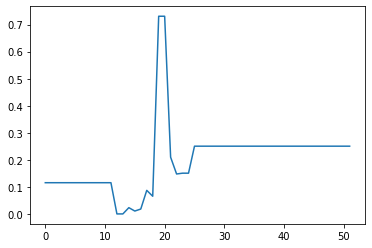

In [35]:
test_data = test_predictions_given_first_n_data(test.loc[test['year']==2008, test.columns != 'motiles'], 25)
plt.plot(fitted_model.predict(test_data))

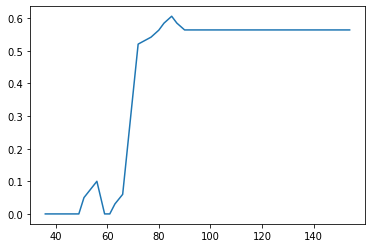

In [36]:
plt.plot(test.loc[test['year']==2008, 'motiles'])

2011 Predictions

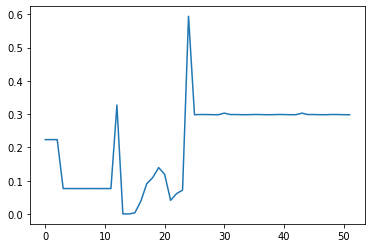

In [366]:
test_data = test_predictions_given_first_n_data(test.loc[test['year']==2011, test.columns != 'motiles'], 25)
plt.plot(fitted_model.predict(test_data))

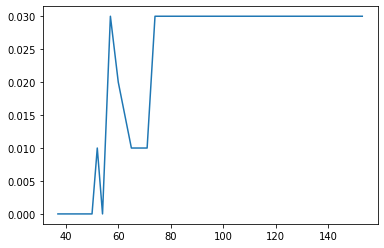

In [367]:
plt.plot(test.loc[test['year']==2011, 'motiles'])

2016 Predictions

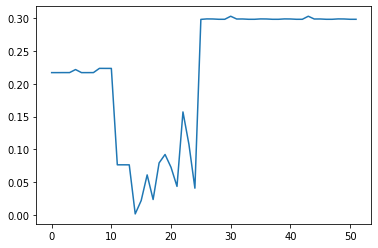

In [368]:
test_data = test_predictions_given_first_n_data(test.loc[test['year']==2016, test.columns != 'motiles'], 25)
plt.plot(fitted_model.predict(test_data))

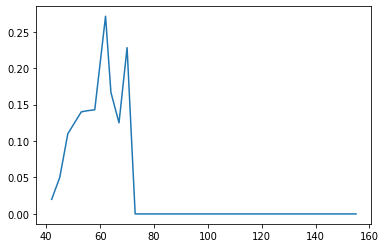

In [369]:
plt.plot(test.loc[test['year']==2016, 'motiles'])